# Removal of cell-cycle and sex covariates (robustnesss to removal of marker genes)


We show consider a dataset of Drosophila myoblasts [[1]](https://doi.org/10.7554/eLife.61276). We show that that conditioning on the gene expression from cell sex and cell cycle marker genes `SiFT` is able to deconfound cell sex and cell cycle effects while preserving signal from the other genes.

[[1] Everetts, N. J., Worley, M. I., Yasutomi, R., Yosef, N., & Hariharan, I. K. (2021). Single-cell transcriptomics of the Drosophila wing disc reveals instructive epithelium-to-myoblast interactions. Elife, 10, e61276.](https://doi.org/10.7554/eLife.61276)

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scvi
import anndata
import pandas as pd
import scanpy as sc
import numpy as np

import os
import sys
import seaborn as sns 
import matplotlib.pyplot as plt
import time
from scipy.sparse import issparse

import sift

/cs/labs/mornitzan/zoe.piran/venvjax/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/cs/labs/mornitzan/zoe.piran/venvjax/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [3]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

In [4]:
sys.path.append("../../")
from paths import DATA_DIR, FIG_DIR

## Set Parameteres

In [5]:
DATA_DIR = DATA_DIR / "nuisance_drosophila"
FIG_DIR = FIG_DIR / "nuisance_drosophila"

In [6]:
fontsize = 25
size = 4
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.transparent"] = True
plt.rcParams["figure.figsize"] = (size, size)

plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.titleweight"] = 500
plt.rcParams["axes.titlepad"] = 8.0
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["axes.labelweight"] = 500
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["axes.labelpad"] = 6.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False


plt.rcParams["font.size"] = fontsize
# plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', "Computer Modern Sans Serif", "DejaVU Sans"]
plt.rcParams['font.weight'] = 500

plt.rcParams['xtick.labelsize'] = fontsize-4
plt.rcParams['xtick.minor.size'] = 1.375
plt.rcParams['xtick.major.size'] = 2.75
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['xtick.minor.pad'] = 2

plt.rcParams['ytick.labelsize'] = fontsize-4
plt.rcParams['ytick.minor.size'] = 1.375
plt.rcParams['ytick.major.size'] = 2.75
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['ytick.minor.pad'] = 2

plt.rcParams["legend.fontsize"] = fontsize+4
plt.rcParams['legend.handlelength'] = 1.4 
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.scatterpoints'] = 1
plt.rcParams['legend.frameon'] = False

plt.rcParams['lines.linewidth'] = 1.7

DPI = 300

sns.set(rc={"figure.dpi":300, "savefig.dpi":300})
plt.style.use("seaborn-whitegrid")
sns.set_style("whitegrid", {"xtick.direction": "out", "xtick.major.size": 3.0, "xtick.minor.size": 3.0,
                            "ytick.color": ".15", "ytick.direction": "out", "ytick.major.size": 3.0, 
                            "ytick.minor.size": 3.0, "font": ["DejaVu Sans"], "font.scale": 1, 
                            "legend.frameon":"True"})

In [7]:
method_colors = ["#5C88DAFF", "#84BD00FF", "#FFCD00FF", "#7C878EFF"] 
coupled_method_colors = ["#5C88DAFF", "#5C88DA99", "#84BD00FF",  "#84BD0099", "#FFCD00FF", "#7C878EFF"]

## Helper functions

### Set adata colors

In [8]:
def set_adata_colors(adata):
    # set sex
    adata.uns["sex_colors"] = list(sns.color_palette("colorblind", 2).as_hex()[::-1])
    
    # set phase
    adata.obs["phase"] = adata.obs["phase"].astype("category")
    adata.obs["phase"] = adata.obs["phase"].cat.reorder_categories(['G1',  'S', 'G2M'])
    
    colors_ = list(sns.color_palette("Paired", 6).as_hex())
    adata.uns["phase_colors"] = [colors_[1], colors_[3], colors_[5]]
    
    # set batch
    adata.obs["batch_str"] = adata.obs["batch"].copy()
    adata.obs["batch_str"] = adata.obs["batch_str"].cat.rename_categories({
        '96hr_1': "96hr (1)", 
        '96hr_2': "96hr (2)", 
        '120hr_1': "120hr (1)", 
        '120hr_2': "120hr (2)", 
    })
    adata.uns["batch_str_colors"] = ["#92aeb3", "#c9c89d", "#999999", "#392b2b"]

    # set phase-sex
    adata.obs["phase_sex"] = adata.obs["phase"].astype(str) + "_" + adata.obs["sex"].astype(str)
    adata.obs["phase_sex"] = adata.obs["phase_sex"].astype("category")
    adata.obs["phase_sex"] = adata.obs["phase_sex"].cat.reorder_categories([
        'G1_female',  'G1_male', 
        'S_female',  'S_male', 
        'G2M_female',  'G2M_male', 
    ])
    adata.obs["phase_sex"] = adata.obs["phase_sex"].cat.rename_categories({
        'G1_female' : "G1 (f)",  
        'G1_male': "G1 (m)",
        'S_female': "S (f)",  
        'S_male': "S (m)",
        'G2M_female': "G2M (f)",
        'G2M_male': "G2M (m)", 
    })
    adata.uns["phase_sex_colors"] = list(sns.color_palette("Paired", 6).as_hex())
    

    
    return adata

## Setting parameteres

In [9]:
# list of sex genes and cell cycle genes we will be conditioning on
sex_genes = ["lncRNA:roX1", "lncRNA:roX2", "Sxl", "msl-2"]

cell_cycle_genes = ['PCNA', 'dnk', 'RnrS', 'RnrL', 'Claspin', 'Mcm5', 'Caf1-180',
       'RPA2', 'HipHop', 'stg', 'Mcm6', 'dup', 'WRNexo', 'Mcm7', 'dpa',
       'CG10336', 'Mcm3', 'Mcm2', 'RpA-70', 'Chrac-14', 'CG13690', 'RPA3',
       'asf1', 'DNApol-alpha73', 'CycE', 'DNApol-alpha50',
       'Kmn1', 'Lam', 'Nph', 'msd5', 'msd1', 'ctp', 'Set', 'scra',
       'Chrac-16', 'ncd', 'Ote', 'pzg', 'HDAC1', 'nesd', 'tum', 'CG8173',
       'aurB', 'feo', 'pav', 'CG6767', 'sip2', 'Det', 'Cks30A', 'CycB',
       'B52']

# list of genes we're interested in
genes_of_interest = [
    "Argk",
    "Nrt",
    "Ten-a",
    "Ten-m",
    "wb",
    "Act57B",
    "drl",
    "mid",
    "nemy",
    "lms",
    "CG11835",
    "Gyg",
    "ara",
    "tok",
    "kirre",
    "NK7.1",
    "fj",
    "beat-IIIc",
    "CG33993",
    "dpr16",
    "CG15529",
    "CG9593",
    "beat-IIb",
    "robo2",
    "Ama",
    "fz2",
    "elB",
    "noc",
    "nkd",
    "fng",
    "vg",
]

nuisance_genes = sex_genes + cell_cycle_genes

library_size = 5000

In [10]:
## robustness genes
num_genes = 10
num_reps = 10

nuisance_genes_dict = {}
for rep in range(num_reps):
    background_genes = np.random.choice(genes_of_interest, num_genes)
    nuisance_genes_filter = np.random.choice(nuisance_genes, len(nuisance_genes)-num_genes)
    nuisance_genes_dict[rep] = np.concatenate([nuisance_genes_filter, background_genes])

In [11]:
nuisance_genes_dict

{0: array(['WRNexo', 'RPA2', 'Cks30A', 'RPA2', 'lncRNA:roX2', 'CG10336',
        'CycB', 'Chrac-14', 'aurB', 'CycE', 'Mcm2', 'RnrL', 'RPA2',
        'lncRNA:roX1', 'CG6767', 'pav', 'Caf1-180', 'ctp', 'Caf1-180',
        'RPA3', 'sip2', 'Mcm6', 'RPA3', 'CycB', 'Mcm3', 'PCNA', 'CG6767',
        'Caf1-180', 'HDAC1', 'Chrac-14', 'msd5', 'lncRNA:roX1', 'CG6767',
        'Mcm2', 'DNApol-alpha73', 'B52', 'Nph', 'CG13690', 'Set', 'Kmn1',
        'CG6767', 'tum', 'Kmn1', 'ncd', 'Set', 'beat-IIIc', 'ara', 'drl',
        'Ten-m', 'noc', 'tok', 'CG11835', 'noc', 'fng', 'Argk'],
       dtype='<U14'),
 1: array(['Set', 'Set', 'Chrac-16', 'WRNexo', 'CG13690', 'Mcm6', 'Chrac-14',
        'asf1', 'CG13690', 'RnrS', 'stg', 'DNApol-alpha50', 'aurB', 'Kmn1',
        'Mcm7', 'lncRNA:roX1', 'PCNA', 'lncRNA:roX2', 'Det', 'Caf1-180',
        'RpA-70', 'Lam', 'RPA2', 'ctp', 'Mcm6', 'sip2', 'CycE', 'PCNA',
        'dnk', 'Caf1-180', 'msd1', 'Nph', 'HDAC1', 'lncRNA:roX2', 'RPA3',
        'Mcm6', 'DNApol-alpha50'

## Pre-process data

In [ ]:
# setting up anndata
adata = sc.read("/cs/labs/mornitzan/zoe.piran/research/projects/SiFT_analysis/cellcycle_myoblasts/data/myoblasts.h5ad")
# adata = sc.read(DATA_DIR / 'myoblasts.h5ad')

In [ ]:
adata.layers['counts'] = adata.X.copy() # move count data into a layer
sc.pp.normalize_total(adata, target_sum = library_size)
sc.pp.log1p(adata) # log the data for better umap visualization later
adata.raw = adata

**Classify the `sex`**

based on the classification performed by Everetts et. al. [[1]]((https://doi.org/10.7554/eLife.61276)) (see [cell_sex_and_cell_cycle_correction.R](https://github.com/HariharanLab/Everetts_Worley_Yasutomi/blob/e1d1f10fefdab11688ad4ca0b8c2684ed47faa0c/scVI/cell_sex_and_cell_cycle_correction.R))

_We expect the data for sex genes to be bimodal, and use the minimum between peaks as a cutoff for determining male and female cells. This usually corresponds to the second extrema in the density (from left to right). However, noise and drop-outs in the data may make this difficult to calculate, so a manual cutoff may be needed instead._
  

In [ ]:
from rpy2 import robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import vectors

stats = importr("stats")

sex_gene_cutoff = {}
data_density = {}
sex_threshold_cells = {}
sex_genes = ["lncRNA:roX1", "lncRNA:roX2"]

# get density estimate

for i, gene in enumerate(sex_genes):
    column = vectors.FloatVector(adata[:, gene].X)
    data_density[gene]  = stats.density(column, adjust = 2)
    x = np.asarray(data_density[gene][0])
    y = np.asarray(data_density[gene][1])
    # find the second extrema in the density, and use this as a cutoff for cells
    sex_gene_cutoff[gene] = x[np.where(np.diff(np.diff(y) > 0))][1]
    adata.obs[f"{gene}_cutoff"] = adata[:, gene].X >= sex_gene_cutoff[gene]
    
    ax = sns.histplot(adata[:, gene].X, stat="density", bins=50, kde=True)
    ax.legend().remove()
    ax.set_xlabel(f"Log normalized counts\n{gene}")
    ax.set_ylabel(f"density")
    plt.axvline(x=sex_gene_cutoff[gene],color='red')
    plt.title(f"{gene}, cutoff={sex_gene_cutoff[gene]:.2f}")
    
    plt.tight_layout()
    # plt.savefig(FIG_DIR / f"sex_cutoff_{gene}.png", bbox_inches="tight", dpi=DPI)
    plt.show()
    
adata.obs["sex"] = "female"
adata.obs.loc[adata.obs["lncRNA:roX1_cutoff"] | adata.obs["lncRNA:roX2_cutoff"], "sex"]  = "male"


num_male = (adata.obs["sex"] == "male").sum()
num_female = (adata.obs["sex"] == "female").sum()
print(f"Number of predicted male cells: {num_male}, percentage from data: {num_male/(num_male+num_female):.2f}")
print(f"Number of predicted female cells: {num_female}, percentage from data: {num_female/(num_male+num_female):.2f}")

Classify cell cycle based on cell cycle genes from Kirchner [Drosophila_melanogaster.csv](https://github.com/hbc/tinyatlas/blob/master/cell_cycle/Drosophila_melanogaster.csv) as used in Zhu et al. [[2]](https://doi.org/10.1038/s41467-022-28915-3)

[[2] Kiat, Y., Vortman, Y., & Sapir, N. (2019). Feather moult and bird appearance are correlated with global warming over the last 200 years. Nature Communications, 10(1), 1-7.](https://doi.org/10.1038/s41467-022-28915-3)


In [ ]:
g2m_genes = [
    'Mps1', 'aurA', 'CycB', 'fzy', 'twe', 'pbl', 'RanGAP', 'stg',
    'sub', 'Su(var)205', 'Cdk1', 'Klp61F', 'pie', 'pav', 'glu', 'msps',
    'pigs', 'Nek2', 'HP1b', 'Phf7', 'Bub1', 'mars', 'Mapmodulin',
    'LBR', 'CTCF', 'Cks85A', 'HP1e', 'HP1c', 'Cap-D2', 'cmet', 'cana',
    'scra', 'BubR1', 'Det', 'vih', 'Dsp1', 'Top2'
]
s_genes = [
    'Blm', 'spn-A', 'PCNA', 'CycE', 'RnrS', 'DNApol-alpha50',
    'l(2)dtl', 'Mcm2', 'spel1', 'tos', 'dpa', 'Mcm5', 'Ts', 'Mcm6',
    'Fen1', 'Cdc45', 'Usp1', 'CG15141', 'CG10336', 'PCNA2', 'RPA2',
    'Caf1-105', 'CG11788', 'Cdc6', 'Slbp', 'Claspin',
    'DNApol-alpha180', 'RfC4', 'Psf2'
]

In [ ]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

In [ ]:
adata = set_adata_colors(adata)

In [ ]:
adata_nothing = adata.copy()

In [ ]:
sc.pp.scale(adata_nothing)
sc.tl.pca(adata_nothing)
sc.pp.neighbors(adata_nothing)
sc.tl.umap(adata_nothing)

In [ ]:
fig = sc.pl.umap(
        adata_nothing,
        color=["batch_str", "sex",  "phase", "phase_sex"],
        frameon=False,
        wspace=0,
        return_fig=True,
    )
fig.axes[2].set_title("cell cycle phase")
fig.axes[3].set_title("cc phase & sex")
plt.show()

In [ ]:
adata = adata[adata.obs["phase_sex"].argsort(), :]

In [ ]:
adata_nothing = adata_nothing[adata_nothing.obs["phase_sex"].argsort(), :]

In [ ]:
adata_nothing.write(DATA_DIR / "myoblasts_nothing.h5ad")

In [ ]:
adata.write(DATA_DIR / "myoblasts_annotated.h5ad")

## Read pre-processed `adata`

In [12]:
methods = ["sift", "regress_out", "scvi_cond", "nothing"]
fnames = {f"{method}_{rep}": DATA_DIR / f"myoblasts_{method}_{rep}_robust_genes.h5ad" for method in methods for rep in range(num_reps)}

In [13]:
adata = sc.read(DATA_DIR / "myoblasts_annotated.h5ad")

In [14]:
adata

AnnData object with n_obs × n_vars = 19885 × 3387
    obs: 'batch', 'lncRNA:roX1_cutoff', 'lncRNA:roX2_cutoff', 'sex', 'S_score', 'G2M_score', 'phase', 'batch_str', 'phase_sex'
    uns: 'batch_str_colors', 'cell_cycle_genes', 'log1p', 'phase_colors', 'phase_sex_colors', 'sex_colors', 'sex_genes'
    layers: 'counts'

In [15]:
adatas_ = {}

# `SiFT`

In [16]:
metric = "knn"
method = methods[0]
n_neighbors = 3

In [17]:
# setting up anndata for sift

for rep in range(num_reps):
    adatas_[f"{method}_{rep}"] = adata.copy()
    
    # then copy the expression of the nuisance gene into adata.obsm
    adatas_[f"{method}_{rep}"].obsm["nuisance_genes"] = adatas_[f"{method}_{rep}"][:, nuisance_genes_dict[rep]].X
    adatas_[f"{method}_{rep}"].uns["nuisance_genes"] = nuisance_genes_dict[rep]
    
    
    # finally, remove the original nuisance genes from the anndata
    gene_subset = [g for g in adatas_[f"{method}_{rep}"].var_names if g not in nuisance_genes_dict[rep]]
    adatas_[f"{method}_{rep}"] = adatas_[f"{method}_{rep}"][:, gene_subset].copy()


In [18]:
for rep in range(num_reps): 
    print(f"running {method}_{rep}")    
    kernel_key_ =  "nuisance_genes"     

    sft = sift.SiFT(
        adata=adatas_[f"{method}_{rep}"],
        kernel_key=kernel_key_,
        n_neighbors=n_neighbors,
        metric=metric,
        copy=False,
    )
    sft.filter(
        embedding_key="X",
        pseudocount=False
        )
    print(f"{method} rep={rep} finished.")


running sift_0


/cs/labs/mornitzan/zoe.piran/venvjax/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/cs/labs/mornitzan/zoe.piran/venvjax/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/cs/labs/mornitzan/zoe.piran/venvjax/lib/python3.9/site-packages/uma

/cs/labs/mornitzan/zoe.piran/venvjax/lib/python3.9/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


INFO     sift: initialized a SiFTer with knn kernel.                                                               
INFO     sift: Filtering cell-cell similarity kernel using projection on `X`.                                      
INFO     sift: The data is `SiFTed`!                                                                               
         The filtered embedding is stored in `adata.X`                                                             
             Finish                                                                                                
sift rep=0 finished.
running sift_1
INFO     sift: initialized a SiFTer with knn kernel.                                                               
INFO     sift: Filtering cell-cell similarity kernel using projection on `X`.                                      
INFO     sift: The data is `SiFTed`!                                                                               
         The filtered embedding is s

In [19]:
for rep in range(num_reps): 
    sc.tl.pca(adatas_[f"{method}_{rep}"])
    sc.pp.neighbors(adatas_[f"{method}_{rep}"])
    sc.tl.umap(adatas_[f"{method}_{rep}"])

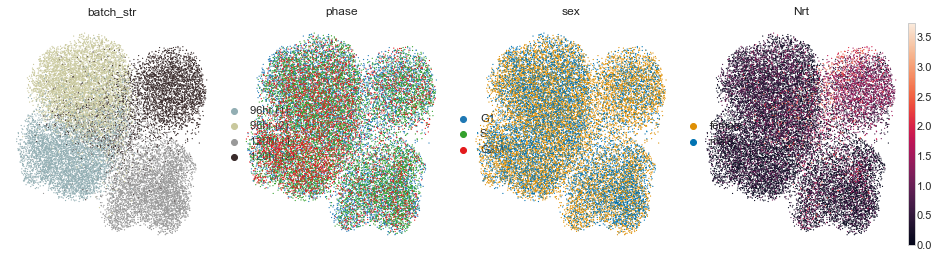

In [20]:
sc.pl.umap(
    adatas_[f"{method}_0"],
    color=["batch_str","phase", "sex", "Nrt"],
    frameon=False,
    wspace=0,
    return_fig=True,
    )

plt.show()    

In [21]:
for rep in range(num_reps): 
    adatas_[f"{method}_{rep}"].write(fnames[f"{method}_{rep}"])

# `regress_out` (`Scanpy`)

We run scanpy's `regress_out()` as a baseline.

In [22]:
method = methods[1]

In [23]:
# setting up anndata

for rep in range(num_reps):
    adatas_[f"{method}_{rep}"] = adata.copy()
    
    # then copy the expression of each nuisance gene into adata.obs where the key
    # is the gene name
    for g in nuisance_genes_dict[rep]:
        exp = adatas_[f"{method}_{rep}"][:, g].X
        adatas_[f"{method}_{rep}"].obs[g] = exp.copy()
    
    # finally, remove the nuisance genes from the anndata
    gene_subset = [g for g in adatas_[f"{method}_{rep}"].var_names if g not in nuisance_genes_dict[rep]]
    adatas_[f"{method}_{rep}"] = adatas_[f"{method}_{rep}"][:, gene_subset].copy()

In [24]:
# takes ~ 15 min to run 
for rep in range(num_reps):
    print(f"running {method}_{rep}")
    adatas_[f"{method}_{rep}"] = sc.pp.regress_out(adatas_[f"{method}_{rep}"], list(nuisance_genes_dict[rep]), copy=True)
    print(f"{method} rep={rep} finished")

running regress_out_0
regress_out rep=0 finished
running regress_out_1
regress_out rep=1 finished
running regress_out_2
regress_out rep=2 finished
running regress_out_3
regress_out rep=3 finished
running regress_out_4
regress_out rep=4 finished
running regress_out_5
regress_out rep=5 finished
running regress_out_6
regress_out rep=6 finished
running regress_out_7
regress_out rep=7 finished
running regress_out_8
regress_out rep=8 finished
running regress_out_9
regress_out rep=9 finished


In [25]:
for rep in range(num_reps):
    sc.tl.pca(adatas_[f"{method}_{rep}"])
    sc.pp.neighbors(adatas_[f"{method}_{rep}"])
    sc.tl.umap(adatas_[f"{method}_{rep}"])

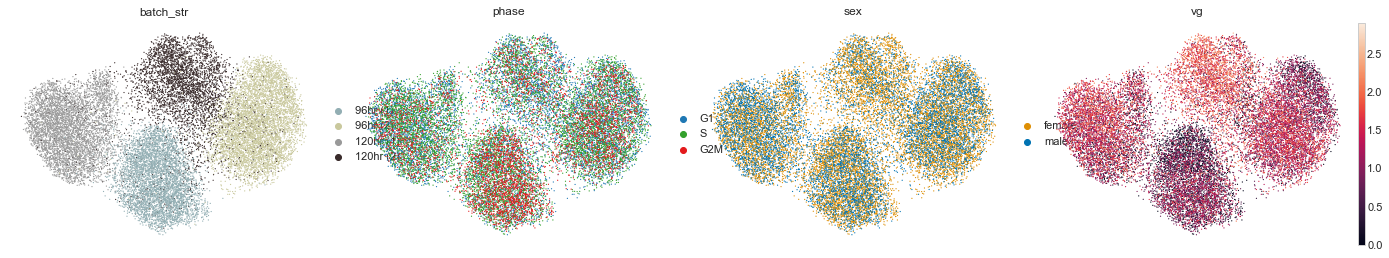

In [26]:
sc.pl.umap(
    adatas_[f"{method}_0"],
    color=["batch_str", "phase", "sex", "vg"],
    frameon=False,
    wspace=0,
    return_fig=True,
    )

plt.show()

In [27]:
for rep in range(num_reps):
    adatas_[f"{method}_{rep}"].write(fnames[f"{method}_{rep}"])

# scVI (only extra covariates)

We train scVI on extra categorical covariates. 

In our case, we would like to condition our latent represenation on cell cycle and cell sex gene expression in order to learn a latent representation that is independant of cell sex and cell cycle. 

In [28]:
method = methods[2]

In [29]:
# setting up anndata

for rep in range(num_reps):
    adatas_[f"{method}_{rep}"] = adata.copy()
    
    # then copy the expression of each nuisance gene into adata.obs where the key
    # is the gene name
    for g in nuisance_genes_dict[rep]:
        exp = adatas_[f"{method}_{rep}"][:, g].X
        adatas_[f"{method}_{rep}"].obs[g] = exp.copy()
    
    # finally, remove the nuisance genes from the anndata
    gene_subset = [g for g in adatas_[f"{method}_{rep}"].var_names if g not in nuisance_genes_dict[rep]]
    adatas_[f"{method}_{rep}"] = adatas_[f"{method}_{rep}"][:, gene_subset].copy()
    
    # run setup_anndata with our list of nuisance genes as our continuous covariates
    scvi.model.SCVI.setup_anndata(adatas_[f"{method}_{rep}"],
                                  continuous_covariate_keys=nuisance_genes_dict[rep], 
                                  layer='counts')

## Train and process

In [30]:
for rep in range(num_reps):
    cond_model = scvi.model.SCVI(adatas_[f"{method}_{rep}"])
    cond_model.train()
    adatas_[f"{method}_{rep}"].obsm["X_emb"] = cond_model.get_latent_representation()
    adatas_[f"{method}_{rep}"].layers["X"] =  adatas_[f"{method}_{rep}"].X.copy()
    adatas_[f"{method}_{rep}"].layers["X_scvi_norm"] = cond_model.get_normalized_expression(adatas_[f"{method}_{rep}"], library_size = library_size)
    
    # log1p scvi normalized expression
    adatas_[f"{method}_{rep}"].layers["scvi_norm_log"] = np.log1p(adatas_[f"{method}_{rep}"].layers["X_scvi_norm"])
    
    # set layer to scvi_norm_log prior to scaling and clustering
    adatas_[f"{method}_{rep}"].X = adatas_[f"{method}_{rep}"].layers["scvi_norm_log"]
    
    # scale expression
    sc.pp.scale(adatas_[f"{method}_{rep}"])
    
    sc.pp.neighbors(adatas_[f"{method}_{rep}"], use_rep = "X_emb")
    sc.tl.umap(adatas_[f"{method}_{rep}"])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 400/400: 100%|██████████| 400/400 [05:23<00:00,  1.33it/s, v_num=1, train_loss_step=2.6e+3, train_loss_epoch=2.57e+3] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [05:23<00:00,  1.24it/s, v_num=1, train_loss_step=2.6e+3, train_loss_epoch=2.57e+3]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 400/400: 100%|██████████| 400/400 [05:02<00:00,  1.31it/s, v_num=1, train_loss_step=2.61e+3, train_loss_epoch=2.57e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [05:02<00:00,  1.32it/s, v_num=1, train_loss_step=2.61e+3, train_loss_epoch=2.57e+3]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 190/400:  48%|████▊     | 190/400 [02:23<02:38,  1.33it/s, v_num=1, train_loss_step=2.58e+3, train_loss_epoch=2.58e+3]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Visualization
Here we visualize the latent space of our `scVI` model trained with expression from our nuisance genes as a continuous covariate.

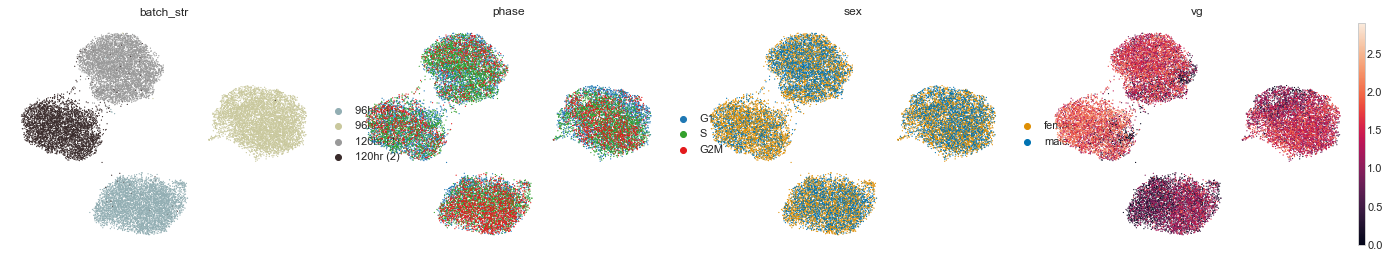

In [31]:
fig = sc.pl.umap(
    adatas_[f"{method}_0"],
    color=["batch_str", "phase", "sex", "vg"],
    frameon=False,
    wspace=0,
    return_fig=True,
    )

plt.show()

In [32]:
for rep in range(num_reps):
    adatas_[f"{method}_{rep}"].write(fnames[f"{method}_{rep}"])

# Nothing

In [33]:
method = methods[3]

In [34]:
adatas_[method] = adata.copy()
sc.pp.scale(adatas_[method])
sc.tl.pca(adatas_[method])
sc.pp.neighbors(adatas_[method])
sc.tl.umap(adatas_[method])

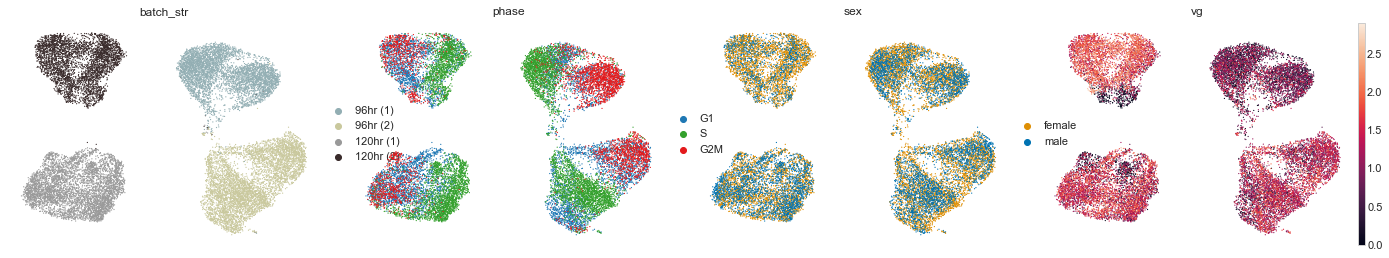

In [35]:
fig = sc.pl.umap(
    adatas_[method],
    color=["batch_str","phase", "sex", "vg"],
    frameon=False,
    wspace=0,
    return_fig=True,
)
plt.show()

In [36]:
adatas_[method].write(fnames[f"{method}_0"])

In [37]:
fnames

{'sift_0': '/cs/labs/mornitzan/zoe.piran/research/projects/SiFT_analysis/cellcycle_myoblasts/data/myoblasts_sift_0_robust_genes.h5ad',
 'sift_1': '/cs/labs/mornitzan/zoe.piran/research/projects/SiFT_analysis/cellcycle_myoblasts/data/myoblasts_sift_1_robust_genes.h5ad',
 'sift_2': '/cs/labs/mornitzan/zoe.piran/research/projects/SiFT_analysis/cellcycle_myoblasts/data/myoblasts_sift_2_robust_genes.h5ad',
 'sift_3': '/cs/labs/mornitzan/zoe.piran/research/projects/SiFT_analysis/cellcycle_myoblasts/data/myoblasts_sift_3_robust_genes.h5ad',
 'sift_4': '/cs/labs/mornitzan/zoe.piran/research/projects/SiFT_analysis/cellcycle_myoblasts/data/myoblasts_sift_4_robust_genes.h5ad',
 'sift_5': '/cs/labs/mornitzan/zoe.piran/research/projects/SiFT_analysis/cellcycle_myoblasts/data/myoblasts_sift_5_robust_genes.h5ad',
 'sift_6': '/cs/labs/mornitzan/zoe.piran/research/projects/SiFT_analysis/cellcycle_myoblasts/data/myoblasts_sift_6_robust_genes.h5ad',
 'sift_7': '/cs/labs/mornitzan/zoe.piran/research/proje

# Analysis

In [38]:
import scib

In [39]:
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Import data

In [ ]:
methods = ["sift", "regress_out", "scvi_cond", "nothing"]

In [ ]:
adatas_ = {}

In [ ]:
for method in methods:
    adatas_[method] = sc.read(fnames[method])

## Quantitive analysis - `iLISI graph score` and `hvg`s

In [40]:
metrics_eval = ["ilisi",]
batch_keys = ["phase", "phase_sex"]

scores_rep = {}
for metric_ in metrics_eval:
    for key_ in batch_keys:
        scores_rep[f"{metric_}_{key_}"]  = {}

In [41]:
methods_cmp = {
    'sift': "SiFT",
    'regress_out': "regress_out", 
    'scvi_cond': "scVI", 
    'nothing' : "Original data", 
}

In [42]:
for method in methods_cmp:
    for batch_key in batch_keys:
        scores_rep[f"ilisi_{batch_key}"][f"{method}"] = []

    num_reps_method = 1 if method == "nothing" else num_reps
    for rep in range(num_reps_method):
        if method == "nothing":
            cname = method
        else:
            cname = f"{method}_{rep}"
        for batch in adatas_[cname].obs["batch"].cat.categories:
            adata_c = adatas_[cname][adatas_[cname].obs["batch"].isin([batch])].copy()
                    
            for batch_key in batch_keys:
                print(f"{method}-{batch_key}-{rep}-{batch}")
                # iLISI
                params = {
                        "adata": adata_c,
                        "batch_key": batch_key,
                        "type_": "embed" if "X_emb" in adata_c.obsm else "full",
                        "n_cores": 1,
                        "subsample": 0.5 * 100,
                    }
            
                scores_rep[f"ilisi_{batch_key}"][f"{method}"].append(scib.metrics.ilisi_graph(
                            **params
                    ))
            

          

sift-phase-0-96hr_1
sift-phase_sex-0-96hr_1
sift-phase-0-96hr_2
sift-phase_sex-0-96hr_2
sift-phase-0-120hr_1
sift-phase_sex-0-120hr_1
sift-phase-0-120hr_2
sift-phase_sex-0-120hr_2
sift-phase-1-96hr_1
sift-phase_sex-1-96hr_1
sift-phase-1-96hr_2
sift-phase_sex-1-96hr_2
sift-phase-1-120hr_1
sift-phase_sex-1-120hr_1
sift-phase-1-120hr_2
sift-phase_sex-1-120hr_2
sift-phase-2-96hr_1
sift-phase_sex-2-96hr_1
sift-phase-2-96hr_2
sift-phase_sex-2-96hr_2
sift-phase-2-120hr_1
sift-phase_sex-2-120hr_1
sift-phase-2-120hr_2
sift-phase_sex-2-120hr_2
sift-phase-3-96hr_1
sift-phase_sex-3-96hr_1
sift-phase-3-96hr_2
sift-phase_sex-3-96hr_2
sift-phase-3-120hr_1
sift-phase_sex-3-120hr_1
sift-phase-3-120hr_2
sift-phase_sex-3-120hr_2
sift-phase-4-96hr_1
sift-phase_sex-4-96hr_1
sift-phase-4-96hr_2
sift-phase_sex-4-96hr_2
sift-phase-4-120hr_1
sift-phase_sex-4-120hr_1
sift-phase-4-120hr_2
sift-phase_sex-4-120hr_2
sift-phase-5-96hr_1
sift-phase_sex-5-96hr_1
sift-phase-5-96hr_2
sift-phase_sex-5-96hr_2
sift-phase-5

In [43]:
df_scores_rep = pd.DataFrame(scores_rep).T 
df_scores_rep = df_scores_rep.reset_index()
df_scores_rep = df_scores_rep.melt(id_vars=["index"]).rename(columns = {'index':'metric', 'value':'score', "variable":"method"}, inplace = False)
df_scores_rep[[str(rep) for rep in range(num_reps * 4)]] = pd.DataFrame(df_scores_rep.score.tolist(), index=df_scores_rep.index)
del df_scores_rep["score"]

df_scores_rep = df_scores_rep.melt(id_vars=["metric", "method"])
df_scores_rep

,metric,method,variable,value
0,ilisi_phase,sift,0,0.765873
1,ilisi_phase_sex,sift,0,0.630836
2,ilisi_phase,regress_out,0,0.753762
3,ilisi_phase_sex,regress_out,0,0.606826
4,ilisi_phase,scvi_cond,0,0.737034
...,...,...,...,...
315,ilisi_phase_sex,regress_out,39,0.467914
316,ilisi_phase,scvi_cond,39,0.645018
317,ilisi_phase_sex,scvi_cond,39,0.343629
318,ilisi_phase,nothing,39,NaN


### Save score

In [44]:
df_scores_rep.to_csv(DATA_DIR / "ilisi_hvg_scores_batch_reps_robust_genes.csv")

### Plot score

In [45]:
df_scores_batch_orig = pd.read_csv(DATA_DIR / "ilisi_hvg_scores_batch.csv", index_col=0)

In [46]:
df_scores_batch_orig = df_scores_batch_orig[df_scores_batch_orig["metric"].isin(["ilisi_phase", "ilisi_phase_sex"])]

In [47]:
del df_scores_batch_orig["variable"]

In [63]:
diff = df_scores_batch_orig[df_scores_batch_orig["method"] == "sift"].groupby(["metric"]).mean(["value"]) - df_scores_rep[df_scores_rep["method"] == "sift"].groupby(["metric"]).mean(["value"])
diff["perc"] = (diff["value"]/ df_scores_batch_orig[df_scores_batch_orig["method"] == "sift"].groupby(["metric"]).mean(["value"])["value"])* 100
diff

,value,perc
metric,,
ilisi_phase,0.004589,0.617715
ilisi_phase_sex,0.025512,4.243979


In [62]:
diff = df_scores_batch_orig[df_scores_batch_orig["method"] == "regress_out"].groupby(["metric"]).mean(["value"])-df_scores_rep[df_scores_rep["method"] == "regress_out"].groupby(["metric"]).mean(["value"])
diff["perc"] = (diff["value"] /  df_scores_batch_orig[df_scores_batch_orig["method"] == "regress_out"].groupby(["metric"]).mean(["value"])["value"])* 100
diff

,value,perc
metric,,
ilisi_phase,0.007231,0.982247
ilisi_phase_sex,0.035229,5.907161


In [64]:
diff = df_scores_batch_orig[df_scores_batch_orig["method"] == "scvi_cond"].groupby(["metric"]).mean(["value"])-df_scores_rep[df_scores_rep["method"] == "scvi_cond"].groupby(["metric"]).mean(["value"])
diff["perc"] = (diff["value"] / df_scores_batch_orig[df_scores_batch_orig["method"] == "scvi_cond"].groupby(["metric"]).mean(["value"])["value"] )* 100
diff

,value,perc
metric,,
ilisi_phase,0.093782,13.496109
ilisi_phase_sex,0.095288,16.308235


In [53]:
methods_plot = {
    'sift': "SiFT",
    'regress_out': "regress_out", 
    'scvi_cond': "scVI", 
    'nothing' : 'Original data', 
}

In [54]:
label_title = {"phase":"graph iLISI\n cc phase", "phase_sex": "graph iLISI\ncc phase & sex", "hvg": "HVG overlap"}

metrics_plot =  [f"ilisi_{label}" for label in ["phase", "phase_sex"]] 

df_scores_lim = df_scores_rep[df_scores_rep["metric"].isin(metrics_plot)].copy()
df_scores_lim.loc[:, "metric"] = df_scores_lim.loc[:, "metric"].replace({
        f"ilisi_{label}": label_title[label] for label in ["phase", "phase_sex"]
        
    }, inplace=False)


df_scores_lim = df_scores_lim[df_scores_lim["method"].isin(methods_plot.keys())]

df_scores_lim.loc[:, "method"] =  df_scores_lim.loc[:, "method"].replace({
    'sift': r"SiFT (partial markers)",
    'regress_out': r"regress_out (partial markers)",
    'scvi_cond': r"scVI (partial markers)",
    "nothing": "Original data"
}, inplace=False)

df_scores_lim

,metric,method,variable,value
0,graph iLISI\n cc phase,SiFT (partial markers),0,0.765873
1,graph iLISI\ncc phase & sex,SiFT (partial markers),0,0.630836
2,graph iLISI\n cc phase,regress_out (partial markers),0,0.753762
3,graph iLISI\ncc phase & sex,regress_out (partial markers),0,0.606826
4,graph iLISI\n cc phase,scVI (partial markers),0,0.737034
...,...,...,...,...
315,graph iLISI\ncc phase & sex,regress_out (partial markers),39,0.467914
316,graph iLISI\n cc phase,scVI (partial markers),39,0.645018
317,graph iLISI\ncc phase & sex,scVI (partial markers),39,0.343629
318,graph iLISI\n cc phase,Original data,39,NaN


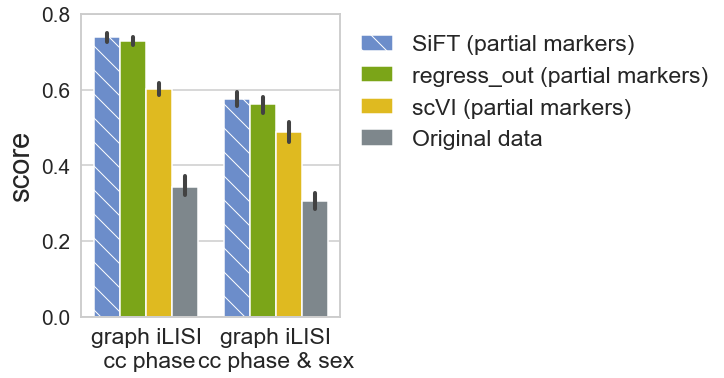

In [57]:
size = 4
fig, axs = plt.subplots(1,1, figsize=(size*2.6, size+1.6))

bar = sns.barplot(x="metric", y="value", data=df_scores_lim, hue="method", ax=axs, palette=method_colors)
# Define some hatches
hatches = [
    '\\', '\\', #'\\',
    '', '', #'', 
    '', '', #'x',
    '', '', #'',
]

# Loop over the bars
for i, thisbar in enumerate(bar.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])
        
leg = axs.legend(ncol=1, 
                    loc="upper left", 
                    bbox_to_anchor=(1.0, 1.0),
                    frameon=False, fontsize=fontsize-2)
plt.title("")
plt.xticks(rotation=0,  fontsize=fontsize-2)
plt.ylim(0, 0.8)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8] ,fontsize=fontsize-4)
plt.xlabel("", fontsize=fontsize-4)
plt.ylabel("score",  fontsize=fontsize+4)
plt.tight_layout()
fig.savefig(FIG_DIR / f"score_iLISI_hvg_batch_robust_genes.png", bbox_inches="tight", dpi=DPI)
plt.show()